<a href="https://colab.research.google.com/github/blufzzz/Dynamic-Texture-3D-CNN/blob/master/DynTex_3D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is demo for dynamic texture synthesis via auto-regresion of the frame sequence

In [0]:
# for name in os.listdir('./'):
#   if 'jpg' in re.findall('\w+', name):
#       os.remove(name)

In [0]:
# root = './data/dynamic_textures_long'
# for fold in tqdm_notebook(os.listdir(root)):
    
#     texture_fold = os.path.join(root, fold)
#     names = os.listdir(texture_fold)
    
#     if len(names) != 1:
#         print ('check', fold)
#         continue
    
#     video = names[0]
#     video_path = os.path.join(texture_fold, video)
    
#     vidcap = cv2.VideoCapture(video_path)
#     success, image = vidcap.read()
#     count = 0
#     success = True
#     while success:
#       cv2.imwrite(os.path.join(texture_fold, 'frame{}.jpg'.format(count)), image)     # save frame as JPEG file
#       success,image = vidcap.read()
#       print ('Read a new frame: ', success)
#       count += 1
      
#     os.remove(video_path)  

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
cd ./gdrive/My\ Drive/Colab Notebooks/AR3DCNN

/content/gdrive/My Drive/Colab Notebooks/AR3DCNN


In [0]:
from skimage import io
import cv2
import os
import sys
import shutil
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython.core.display import clear_output
from IPython.core.debugger import set_trace
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from google.colab import files
from PIL import Image
import matplotlib.animation as anim
from torchvision.transforms import Resize, ToTensor, Compose


# Define model

In [0]:
# class CNN3D(nn.Module):
  
#   def __init__(self):
    
#     super(CNN3D, self).__init__()
    
#     self.d_conv1 = nn.Conv3d(3,64, (2,3,3), stride=1, padding=(0,1,1), bias=True)
#     self.d_bn_1 = nn.BatchNorm3d(64)
#     self.d_pool1 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
    
#     self.d_conv2 = nn.Conv3d(64, 128, (2,3,3), stride=1, padding=(0,1,1), bias=True)
#     self.d_bn_2 = nn.BatchNorm3d(128)
#     self.d_pool2 = nn.MaxPool3d((1,2,2), stride = (1,2,2))

#     self.d_conv3 = nn.Conv3d(128, 256, (1,3,3), stride=1, padding=(0,1,1), bias=True)
#     self.d_bn_3 = nn.BatchNorm3d(256)
#     self.d_pool3 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
    
#     self.d_conv4 = nn.Conv3d(256, 512, (1,3,3), stride=1, padding=(0,1,1), bias=True)
#     self.d_bn_4 = nn.BatchNorm3d(512)
#     self.d_pool4 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
        
    
#     self.u_unconv1 = nn.ConvTranspose2d(512, 256, (2,2), stride = 2, bias=True)
#     self.u_conv1 = nn.Conv2d(256, 256, (3,3), stride = 1, padding=(1,1), bias=True)
    
#     self.u_unconv2 = nn.ConvTranspose2d(256, 128, (2,2), stride = 2, bias=True)
#     self.u_conv2= nn.Conv2d(128, 128, (3,3), stride = 1, padding=(1,1), bias=True)
    
#     self.u_unconv3 = nn.ConvTranspose2d(128, 64, (2,2), stride = 2, bias=True)
#     self.u_conv3 = nn.Conv2d(64, 64, (3,3), stride = 1, padding=(1,1), bias=True)

#     self.u_unconv4 = nn.ConvTranspose2d(64,3, (1,1), stride = 1, bias=True)
#     self.u_conv4 = nn.Conv2d(3, 3, (1,1), stride = 1, bias=True)

#     self.relu = nn.LeakyReLU()
        
#   def forward(self, x):

#     x = self.d_conv1(x)
#     x = self.d_pool1(x)
#     x = self.relu(x)
    
#     x = self.d_conv2(x)
#     x = self.d_pool2(x)
#     x = self.relu(x)
    
#     x = self.d_conv3(x)
#     x = self.d_pool3(x)
#     x = self.relu(x)
    
#     x = self.d_conv4(x)
#     x = self.relu(x)
    
#     x = x.reshape(x.shape[0],
#                   x.shape[1], x.shape[-1], x.shape[-1])
    
#     x = self.u_unconv1(x)
#     x = self.u_conv1(x)
#     x = self.relu(x)
    
#     x = self.u_unconv2(x)
#     x = self.u_conv2(x)
#     x = self.relu(x)
    
#     x = self.u_unconv3(x)
#     x = self.u_conv3(x)
#     x = self.relu(x)
    
#     x = self.u_unconv4(x)
#     x = self.u_conv4(x)
#     x = self.relu(x)    
    
#     return x
  

In [0]:
class CNN3D(nn.Module):
  
  def __init__(self):
    
    super(CNN3D, self).__init__()
    
    self.d_conv1 = nn.Conv3d(3,64, (2,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_bn_1 = nn.BatchNorm3d(64)
    self.d_pool1 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
    
    self.d_conv2 = nn.Conv3d(64, 128, (2,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_bn_2 = nn.BatchNorm3d(128)
    self.d_pool2 = nn.MaxPool3d((1,2,2), stride = (1,2,2))

    self.d_conv3 = nn.Conv3d(128, 256, (1,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_bn_3 = nn.BatchNorm3d(256)
    self.d_pool3 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
    
    self.d_conv4 = nn.Conv3d(256, 512, (1,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_bn_4 = nn.BatchNorm3d(512)
    self.d_pool4 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
        
    
    self.u_unconv1 = nn.ConvTranspose2d(512, 256, (2,2), stride = 2, bias=True)
    self.u_conv1 = nn.Conv2d(256, 256, (3,3), stride = 1, padding=(1,1), bias=True)
    
    self.u_unconv2 = nn.ConvTranspose2d(256, 128, (2,2), stride = 2, bias=True)
    self.u_conv2= nn.Conv2d(128, 128, (3,3), stride = 1, padding=(1,1), bias=True)
    
    self.u_unconv3 = nn.ConvTranspose2d(128, 64, (2,2), stride = 2, bias=True)
    self.u_conv3 = nn.Conv2d(64, 64, (3,3), stride = 1, padding=(1,1), bias=True)

    self.u_unconv4 = nn.ConvTranspose2d(64,3, (1,1), stride = 1, bias=True)
    self.u_conv4 = nn.Conv2d(3, 3, (1,1), stride = 1, bias=True)

    self.relu = nn.LeakyReLU()
        
  def forward(self, x):

    x = self.d_conv1(x)
    x = self.d_pool1(x)
    x = self.relu(x)
    
    x = self.d_conv2(x)
    x = self.d_pool2(x)
    x = self.relu(x)
    
    x = self.d_conv3(x)
    x = self.d_pool3(x)
    x = self.relu(x)
    
    x = self.d_conv4(x)
    x = self.relu(x)
    
    x = x.reshape(x.shape[0],
                  x.shape[1], x.shape[-1], x.shape[-1])
    
    x = self.u_unconv1(x)
    x = self.u_conv1(x)
    x = self.relu(x)
    
    x = self.u_unconv2(x)
    x = self.u_conv2(x)
    x = self.relu(x)
    
    x = self.u_unconv3(x)
    x = self.u_conv3(x)
    x = self.relu(x)
    
    x = self.u_unconv4(x)
    x = self.u_conv4(x)
    x = self.relu(x)    
    
    return x
  

In [0]:
class CNN2D(nn.Module):
  
  def __init__(self, dt = 3):
    
    super(CNN2D, self).__init__()
    
    self.d_conv1 = nn.Conv2d(dt*3,64, (3,3), stride=1, padding=(1,1), bias=True)
    self.d_bn_1 = nn.BatchNorm2d(64)
    self.d_pool1 = nn.MaxPool2d((2,2), stride = 2)
    
    self.d_conv2 = nn.Conv2d(64, 128, (3,3), stride=1, padding=(1,1), bias=True)
    self.d_bn_2 = nn.BatchNorm2d(128)
    self.d_pool2 = nn.MaxPool2d((2,2), stride = 2)

    self.d_conv3 = nn.Conv2d(128, 256, (3,3), stride=1, padding=(1,1), bias=True)
    self.d_bn_3 = nn.BatchNorm2d(256)
    self.d_pool3 = nn.MaxPool2d((2,2), stride = 2)
    
    self.d_conv4 = nn.Conv2d(256, 512, (3,3), stride=1, padding=(1,1), bias=True)
    self.d_bn_4 = nn.BatchNorm2d(512)
    self.d_pool4 = nn.MaxPool2d((2,2), stride = 2)
    
    self.d_conv5 = nn.ConvTranspose2d(512, 16, (1,1), stride = 1, bias=True) # ???
        
    self.fc = nn.Linear(4096, 2048)
    
    self.u_unconv1 = nn.ConvTranspose2d(8, 256, (2,2), stride = 2, bias=True)
    self.u_conv1 = nn.Conv2d(256, 256, (3,3), stride = 1, padding=(1,1), bias=True)
    self.u_bn_1 = nn.BatchNorm2d(256)
    
    self.u_unconv2 = nn.ConvTranspose2d(256, 128, (2,2), stride = 2, bias=True)
    self.u_conv2= nn.Conv2d(128, 128, (3,3), stride = 1, padding=(1,1), bias=True)
    self.u_bn_2 = nn.BatchNorm2d(128)
    
    self.u_unconv3 = nn.ConvTranspose2d(128, 64, (2,2), stride = 2, bias=True)
    self.u_conv3 = nn.Conv2d(64, 64, (3,3), stride = 1, padding=(1,1), bias=True)
    self.u_bn_3 = nn.BatchNorm2d(64)

    self.u_unconv4 = nn.ConvTranspose2d(64,3, (2,2), stride = 2, bias=True)
    self.u_conv4 = nn.Conv2d(3, 3, (1,1), stride = 1, bias=True)
    
    self.relu = nn.LeakyReLU()
        
  def forward(self, x):
  
    if x.dim() == 5:
        x = x.view(x.size(0), x.size(1)*x.size(2), x.size(3), x.size(4))
    
    x = self.d_conv1(x)
    x = self.d_pool1(x)
    x = self.relu(x)
    
    x = self.d_conv2(x)
    x = self.d_bn_2(x)
    x = self.d_pool2(x)
    x = self.relu(x)
    
    x = self.d_conv3(x)
    x = self.d_bn_3(x)
    x = self.d_pool3(x)
    x = self.relu(x)
    
    x = self.d_conv4(x)
    x = self.d_bn_4(x)
    x = self.d_pool4(x)
    x = self.relu(x)
    
    x = self.d_conv5(x)
    
    x = x.view(x.size(0), -1) # flatten
    
    x = self.fc(x)
    x = self.relu(x)
    
    x = x.view(x.size(0), 8, 16, 16)
    
    x = self.u_unconv1(x)
    x = self.u_conv1(x)
    x = self.u_bn_1(x)
    x = self.relu(x)
    
    x = self.u_unconv2(x)
    x = self.u_conv2(x)
    x = self.u_bn_2(x)
    x = self.relu(x)
    
    x = self.u_unconv3(x)
    x = self.u_conv3(x)
    x = self.u_bn_3(x)
    x = self.relu(x)
    
    x = self.u_unconv4(x)
    x = self.u_conv4(x)
    x = self.relu(x)    
    
    return x
  

In [0]:
sorting_key = lambda x: int( re.findall('\d+' ,x)[0])

def get_seq(fold, seq_len, i):
  
  transforms = Compose([Resize((256,256)), ToTensor()])
  
  names = sorted(os.listdir(fold), key = sorting_key)

  imgs = []
  
  pred_name = os.path.join(fold, names[i+seq_len])
  img = Image.open(pred_name)
  y = transforms(img)

  for name in names[i:i+seq_len]:
    
    image_path = os.path.join(fold, name)
    img = Image.open(image_path)
    img_trasformed = transforms(img)
    imgs += [img_trasformed.unsqueeze(1)]
    
  imgs = torch.cat(imgs, 1)
  
  return imgs, y

In [0]:
# def get_seq(fold, seq_len, i):
  
#   names = sorted(os.listdir(fold))
#   imgs = []
  
#   y = io.imread(os.path.join(fold, names[i+seq_len])).transpose(2,0,1)

#   for name in names[i:i+seq_len]:

#     imgs += [io.imread(os.path.join(fold, name)).transpose(2,0,1)]
    
#   imgs = np.array([imgs]).transpose(0,2,1,3,4)
  
#   return torch.squeeze(torch.Tensor(imgs)), torch.Tensor(y)
  
    
def deprocess(img_tensor):

    img = img_tensor[0].detach().cpu().numpy().transpose(1,2,0)
    
    img= np.clip(img, 0, 1)
    img = img.astype('float')

    return  img  

In [0]:
# X,y = get_seq('./data/dynamic_textures/water_1/', 6 ,0)
# X.shape, y.shape
# model.forward(X.view(1,*X.shape).cuda()).shape

In [0]:
class DynTexDataset(Dataset):
  
    def __init__(self, root_dir, texture_names, seq_len, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.texture_names = texture_names
        self.texture_seqlen_dict = {}
        self.seq_len = seq_len

        for name in texture_names:

            texture_fold = os.path.join(root_dir, name)
            n_framesets = len(os.listdir(texture_fold)) - (seq_len + 1)
            self.texture_seqlen_dict[texture_fold] = n_framesets

    def __getitem__(self, idx):

        new_idx = idx

        for texture_fold in self.texture_seqlen_dict.keys():

          if new_idx < self.texture_seqlen_dict[texture_fold]:
              break
          else:
              new_idx -= self.texture_seqlen_dict[texture_fold]
                      
        return get_seq(texture_fold, self.seq_len, new_idx)

    def __len__(self):

        s = 0
        for fold in self.texture_seqlen_dict.keys():
            s+=self.texture_seqlen_dict[fold]
        return s
      
def save_model(textures, batch_size, dt, epoch, model_type = 'cnn3d'):
  
    textures_names = '_'.join(np.unique(re.findall('[a-z,A-Z]+', '_'.join(textures))))
    
    
    PATH = './{0}_training_state_ep{1}_text{2}_bs{3}_dt{4}.pt'.format(model_type,
                                                                      epoch,
                                                                      textures_names,
                                                                      batch_size,
                                                                      dt)

    if not os.path.isfile(PATH):
    
        torch.save({
            'epoch': epoch,
            'dt':dt,
            'batch_size':batch_size,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_history': losses
            }, PATH)


# Train model

In [22]:
root_fold = '../data/dynamic_textures_long/'

os.listdir(root_fold)

['water_5',
 'pool_2',
 'pool_3',
 'calm_water_1',
 'calm_water_2',
 'calm_water_3',
 'calm_water_4',
 'calm_water_5',
 'calm_water_6',
 'calm_water_7',
 'calm_water_8',
 'calm_water_9',
 'calm_water_10',
 'calm_water_11',
 'calm_water_12',
 'calm_water_13',
 'calm_water_14']

In [0]:
textures = ['calm_water_1',
             'calm_water_2',
             'calm_water_3',
             'calm_water_4',
             'calm_water_5',
             'calm_water_6',
             'calm_water_7',
             'calm_water_8',
             'calm_water_9',
             'calm_water_10',
             'calm_water_11',
             'calm_water_12',
             'calm_water_13',
             'calm_water_14']
dt = 3
losses = []
model = CNN2D(dt = dt)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas = (0.8, 0.999))

In [0]:
dyntex_data = DynTexDataset(root_fold, textures, dt)
epoch = 1
epochs = 100
print_freq = epochs // 10
save_freq = 10
batch_size = 20

dataloader = DataLoader(dyntex_data, batch_size=batch_size,
                        shuffle=True, num_workers=5)

In [0]:
# checkpoint = torch.load('./training_state_ep30_textcalm_water_bs20_dt3.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# losses = checkpoint['loss_history']

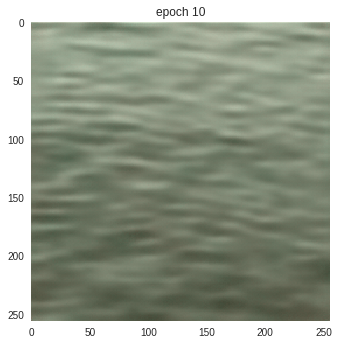

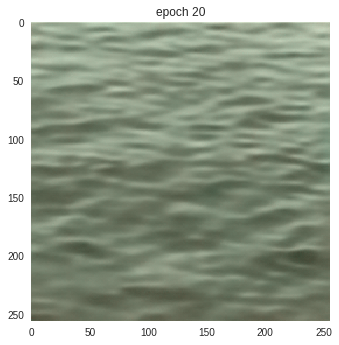

KeyboardInterrupt: ignored

In [26]:
for epoch in tqdm_notebook(range(epoch,epochs + 1)):
  
    model.train()
  
    for seq_batch, y_batch in tqdm_notebook(dataloader):
      
        seq_batch = seq_batch.cuda()
        y_batch = y_batch.cuda()

        optimizer.zero_grad()

        pred = model(seq_batch)

        loss = torch.norm(y_batch - pred) / batch_size
        loss.backward()
        losses += [loss.detach().cpu().numpy()]

        optimizer.step()
  
    # show
    if epoch%print_freq == 0:
        model.eval()
        plt.figure()
        plt.imshow(deprocess(pred))
        plt.title('epoch {}'.format(epoch))
        plt.grid(False)  
        plt.show()
        
    if epoch%save_freq == 0:
        save_model(textures, batch_size, dt, epoch, model_type = 'cnn2d_bn')




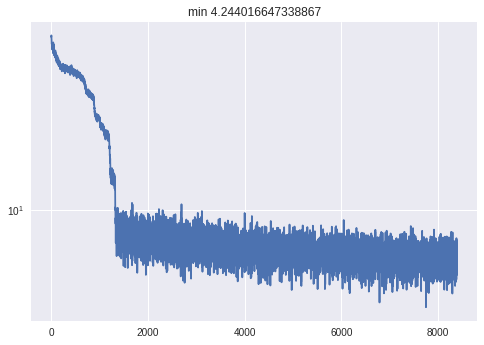

In [27]:
plt.semilogy(range(len(losses)), losses)
plt.title('min {}'.format(min(losses)))
plt.show()

## Generation

In [54]:
texture_type = 'calm_water_1'

texture_fold = os.path.join(root_fold, texture_type)

def generate(model, root_fold,  texture_type, dt = 3, seq_len = 30, one_by_one = True):
  
    fold = os.path.join(root_fold, texture_type)
    N = len(os.listdir(fold))
    model.eval()
    
    assert(seq_len < N)
    
    generate_seq_len = seq_len
    
    starting_seq, _ = get_seq(fold, dt, 0)
    current_seq = starting_seq.unsqueeze(0).cuda()

    generated_imgs = []
    for i in tqdm_notebook(range(generate_seq_len)):
        
        if i >= seq_len:
            break
        
        if not one_by_one:
            if i > N - dt - 1:
                break
              
            current_seq, _ = get_seq(fold, dt, i)
            current_seq = current_seq.unsqueeze(0).cuda()
        
        new_img = model(current_seq)
        generated_imgs += [deprocess(new_img.detach())]  
        
        if one_by_one:
            current_seq = torch.cat([current_seq[:,:,list(range(dt - 1)),...],
                                      new_img.unsqueeze(2)],
                                      2).cuda()
  
    return generated_imgs
        

generated_imgs = generate(model, root_fold,  texture_type, dt = 3, one_by_one = True)


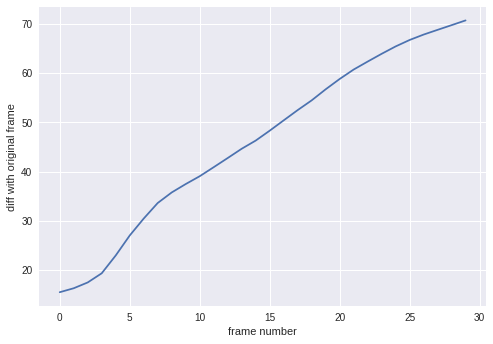

In [61]:
def get_distance(generated_seq, texture_fold):
    
    diff = []
    
    for i, gen_img in enumerate(generated_seq):
      
        img, _ = get_seq(texture_fold, 1, i)
        img = deprocess(img.squeeze().unsqueeze(0))
        
        diff += [np.linalg.norm(img - gen_img)]

    return diff   
  
  
dist = get_distance(generated_imgs, texture_fold)  
plt.plot(dist)
plt.xlabel('frame number')
plt.ylabel('diff with original frame')
plt.show()

## Saving

In [0]:
fold_save = './{}_generated/'.format(texture_type)

def save(generated_imgs, fold_save, download = True):

    if save:
        if not os.path.isdir(fold_save):
            os.mkdir(fold_save)
        else:
            shutil.rmtree(fold_save)
            os.mkdir(fold_save)

    for i,img in enumerate(generated_imgs):
        
        image_name = os.path.join(fold_save, '{}.jpg'.format(i))
        plt.imsave(image_name, img)
        
        if download:
            files.download(image_name)   
            
save(generated_imgs, fold_save)            

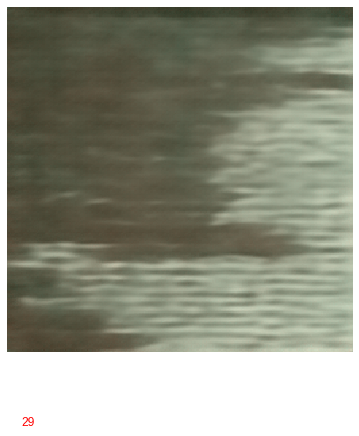

In [67]:
def save_gif(imgs, filename, size=(640, 480)):
    fig = plt.figure()
    fig.set_size_inches(size[0] / 100, size[1] / 100)
    ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
    ax.set_xticks([])
    ax.set_yticks([])
    images = []
    for i, image in enumerate(imgs):
        plt_im = plt.imshow(image, cmap='Greys', vmin=0, vmax=1, animated=True)
        plt_txt = plt.text(10, 310, str(i), color='red')
        images.append([plt_im, plt_txt])

    animation = anim.ArtistAnimation(fig, images)
    animation.save(filename, writer='pillow', fps=1)

 
save(generated_imgs, './anime.gif')

In [68]:
ls -la | grep .gif

-rw------- 1 root root   1615059 Mar 24 19:00 anime.gif
